In [94]:
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from copy import deepcopy
from molecule3d.utils import mol_to_graph_dict
from rdkit.Chem import Draw, rdchem, rdMolAlign
from models.gtmgc import GTMGCCollator, GTMGCForConformerPrediction
from models.mole_bert_tokenizer import MoleBERTTokenizerCollator, MoleBERTTokenizer

In [95]:
sdf_file = Chem.SDMolSupplier(fileName="/lab/Xgk/DataSets/Molecule3D/random/test.sdf", removeHs=False, sanitize=True)

Prepare tokenizer and model

In [96]:
tokenizer = MoleBERTTokenizer.from_pretrained("checkpoints/Tokenizer/Vocab_Size_512")
GTMGC = GTMGCForConformerPrediction.from_pretrained("./checkpoints/CP/GTMGC_Molecule3D_Random")

In [97]:
tokenizer_collator = MoleBERTTokenizerCollator()
gtmgc_collator = GTMGCCollator()

Get mol from SDF file to inference

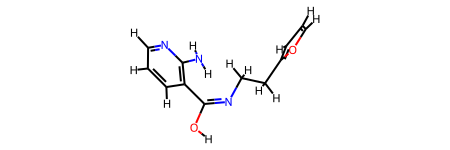

In [98]:
mol = sdf_file[11]
gtmgc_pred_mol = deepcopy(mol)
rdkit_pred_mol = deepcopy(mol)
mol

Tokenize Mol

In [99]:
mol_dict = mol_to_graph_dict(gtmgc_pred_mol)

In [100]:
batch = tokenizer_collator([mol_dict])
mol_dict['input_ids'] = tokenizer(**batch)["quantized_indices"]
mol_dict['input_ids']

tensor([106,  29,  29, 106,  14,  29,  14,  69,   8,   8,   8,  32, 190, 210,
        148, 302, 339, 487, 487, 487, 487, 482, 482, 487, 482, 482, 487, 414,
        414, 490])

Inference on GTMGC

In [101]:
batch = gtmgc_collator([mol_dict])
out = GTMGC(**batch)
conformer_hat = out['conformer_hat'].detach().squeeze().numpy()
out['cdist_mae']

tensor(0.5488)

Get GTMGC predicted mol

In [102]:
conformer_hat_ls = conformer_hat.tolist()
gtmgc_pred_conf = rdchem.Conformer(gtmgc_pred_mol.GetNumAtoms())
for i in range(gtmgc_pred_mol.GetNumAtoms()):
    gtmgc_pred_conf.SetAtomPosition(i, conformer_hat_ls[i])
gtmgc_pred_mol.RemoveConformer(0)
gtmgc_pred_mol.AddConformer(gtmgc_pred_conf)

0

Get RDKit predicted mol

In [103]:
rdkit_pred_mol = Chem.AddHs(rdkit_pred_mol)
AllChem.EmbedMolecule(rdkit_pred_mol, useRandomCoords=True, clearConfs=True)

0

Align predicted mols

In [104]:
rdMolAlign.AlignMol(gtmgc_pred_mol, mol)
rdMolAlign.AlignMol(rdkit_pred_mol, mol)

2.573653422892028

Visualize predicted mol

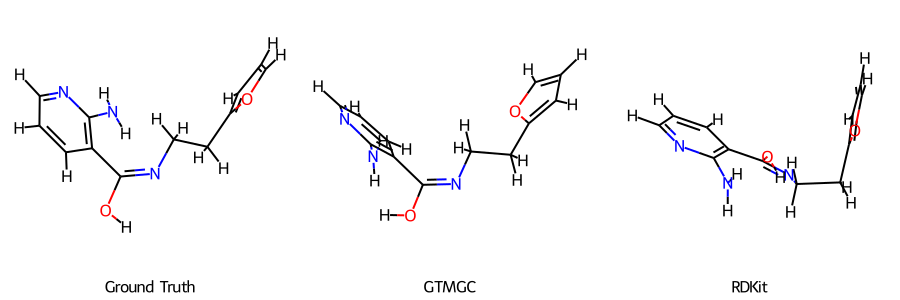

In [105]:
Draw._MolsToGridImage([mol, gtmgc_pred_mol, rdkit_pred_mol], molsPerRow=3, subImgSize=(300, 300), legends=["Ground Truth", "GTMGC", "RDKit"])

Compute RMSD between predicted mol and original mol

In [106]:
mol_hs, gtmgc_pred_mol_hs = Chem.RemoveHs(mol), Chem.RemoveHs(gtmgc_pred_mol) # used in https://arxiv.org/abs/2202.01356
rdkit_pred_mol_hs = Chem.RemoveHs(rdkit_pred_mol) 
rmsd1 = rdMolAlign.GetBestRMS(mol_hs, gtmgc_pred_mol_hs)
rmsd3 = rdMolAlign.GetBestRMS(mol_hs, rdkit_pred_mol_hs)
print(f"RMSD between ground truth and GTMGC: {rmsd1:.3f}")
print(f"RMSD between ground truth and RDKit: {rmsd3:.3f}")

RMSD between ground truth and GTMGC: 1.203
RMSD between ground truth and RDKit: 1.916
